# Structure MCMC

## Gaussian Bayesian Networks

There are two different parameterizations for a joint Gaussian density with different properties.

A multivariate Gaussian distribution over $X_1, X_2, ..., X_n$ is characterized by an $n$ dimensional mean vector $\mu$ and a symmetric $n \times n$ covariance matrix $\Sigma$. The density function is often defined as:

$$p(x) = \frac{1}{(2 \pi)^(n/2)} |\Sigma|^{1/2} exp \left[ -\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x - \mu) \right]$$

where $|\Sigma|$ is the determinant of $\Sigma$. Additionally, $\Sigma$ needs to be *positive semi-definite* for the density function to be well defined.

The notion of a standard Gaussian in the multidimensional case is defined as a Gaussian with zero mean and identity covariance matrix. The density function is then a product of independent standard Gaussians for each of the dimensions. 

Because positive definite matrices are invertible, one can also utilize an alternative parameterization where the Gaussian is defined in terms of its inverse covariance matrix $J = \Sigma^{-1}$, called the *information matrix* or the *precision matrix*. This induces the following alternative form of the density function:

$$- \frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) = -\frac{1}{2} (x - \mu )^T J (x - \mu )$$
$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~=  -\frac{1}{2} (x - \mu )^T  (Jx - J\mu )$$
$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~=  -\frac{1}{2} (x^TJx - x^TJ\mu - \mu^T J x + \mu^T J \mu )$$
$$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~=  -\frac{1}{2} (x^TJx - x^TJ\mu - 2x^TJ\mu + \mu^T J \mu)$$
This leads to
$$p(x) \approx exp\left[ -\frac{1}{2} x^T J x + (J \mu)^Tx \right]$$
where $J \mu$ is called the potential vector. Additionally, in the matrix notation $\mu = E\left[X\right]$ and $\Sigma = E\left[XX^T\right] - E\left[X\right]E\left[X\right]^T$ with $Cov\left[X_i; X_j\right] = E\left[X_i X_j\right] - E\left[X_i\right] E\left[X_j\right]$


### Operations on Gaussians

There are two main operations that we wish to perform on a distribution: compute the marginal distribution over some subset of the variables $Y$, and conditioning the distribution on some assignment of values $Z = Z$. Assume that we have a joint normal distribution over \{ X, Y \} where $X \in \mathbb{R}^n$ and $Y \in \mathbb{R}^m$. The joint distribution is then defined as:

$$p(X,Y) = \mathcal{N} \left( \left( \begin{matrix} \mu_X \\ \mu_Y\end{matrix}  \right); \left[ \begin{matrix} \Sigma_{XX}  & \Sigma_{XY} \\ \Sigma_{YX} & \Sigma{YY} \end{matrix} \right] \right)$$

Then, the marginal Gaussian distribution over any subset of the variables can simply be read from the mean and covariance matrix. To marginalize a Gaussian over a subset of the variables, one essentially needs to compute their pairwise covariances, which is precisely generating the distribution in its covariance form. Similarly, to condition a Gaussian on an observation, one essentially needs to invert the covariance matrix to obtain the information form. For small matrices, inverting a matrix may be feasible, but in high-dimensional spaces, matrix inversion may be far too costly.

### Gaussian Bayesian Networks

We define a Gaussian Bayesian network to be a Bayesian network all of whose variables are continuous, and where all of the CPDs are linear Gaussians.

Let $Y$ be a Gaussian of its parents $X_1, ..., X_k$:

$$p(Y | x) = \mathcal{N}(\beta_0 + \beta^Tx; \sigma^2)$$

Assume that $X_1, ..., X_k$ are jointly Gaussian with distribution $\mathcal{N}( \mu; \Sigma)$$. Then:

- The distribution of $Y$ is a normal distribution $p(Y) = \mathcal{N}(\mu_Y; \sigma^2_Y)$ where
  - $\mu_Y = \beta_0 + \beta^T \mu$
  - $\sigma^2_Y = \sigma^2 + \beta^T \Sigma \beta$
- The joint distribution over {X,Y} is a normal distribution where:
  - $Cov[X_i;Y] = \sum_{j=1}^k \beta_j \Sigma_{i,j}$ 

## Algorithm

Pseudocode for implementing the Metropolis-Hastings algorithm for structure learning in graphs:

```python
Initialize a graph G
For a set number of iterations do:
    Propose a new graph G' by making a small random change to G
    Calculate the acceptance probability A(G, G') as follows:
       Compute the marginal likelihood  P(G | D) and P(G' | D)
       if the proposal distribution is symmetric:
          A(G, G') = min(1, P(G' | D) / P(G | D))
       else:
           Compute the proposal probabilities Q(G | G') and Q(G' | G)
           A(G, G') = min(1, [P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
    Generate a random number u from a uniform distribution between 0 and 1
       if u < A(G, G'), accept the proposed graph: G = G'
return the final graph G
```



## Implementation

In [3]:
import pandas as pd
import numpy as np
import networkx as nx

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import itertools
import random

In [250]:

RESIDUALS = 0
PARAMS = 0

# create a fully connected graph
# todo: add PC algo here
def compute_initial_graph( data : pd.DataFrame ):
    # initialize the graph
    G = nx.DiGraph()
    [G.add_node(node) for node in data.columns]

    G.add_edges_from([('X3', 'X1'), ('X2', 'X1'), ("X1", "X4")])  
    
    
    
    return G

def compute_parent_dict(graph):
    parent_dict = {}
    
    for node in graph.nodes():
        parent_dict[node] = list(graph.predecessors(node))
    return parent_dict

def estimate_bn_params(data, parent_dict):
    
    # Initialize a dictionary to hold the parameters for each node
    params = {}

    # Loop over each node in the network
    for node, parents in parent_dict.items():
        if len(parents) == 0:
            # If the node has no parents, estimate the parameters of the marginal distribution
            mean = np.mean(data.loc[:, node])
            std = np.std(data.loc[:, node])
            params[node] = {'mean': mean, 'std': std}
        else:
            # If the node has parents, estimate the parameters of the conditional distribution
            # todo: one prior for the noise, one prior for the coefficients and one prior for the graph
            reg = LinearRegression().fit(data.loc[:, parents], data.loc[:, node])
            residuals = data.loc[:, node] - reg.predict(data.loc[:, parents])
            std_resid = np.std(residuals)
            params[node] = {'coefficients': reg.coef_, 'intercept': reg.intercept_, 'std_resid': std_resid}

    return params

# score
def compute_log_likelihood(data, params, parent_dict):
    log_likelihood = 0

    for node, node_params in params.items():
        if len(parent_dict[node]) == 0:
            # If the node has no parents, compute the log-likelihood of the data given the marginal distribution
            log_likelihood += norm.logpdf(data.loc[:, node], loc=node_params['mean'], scale=node_params['std'])
        else:
            # If the node has parents, compute the log-likelihood of the data given the conditional distribution
            predicted_values = node_params['intercept'] + np.dot(data.loc[:, parent_dict[node]], node_params['coefficients'])
            residuals = data.loc[:, node] - predicted_values
            log_likelihood += norm.logpdf(residuals.values, loc=0, scale=node_params['std_resid'])
        
            log_likelihood += np.random.gamma(node_params['std_resid'], node_params['std_resid'], 1)
    return log_likelihood

def uniform_prior():
    return 1.0

def compute_gaussian_posterior(graph :  nx.DiGraph, data : pd.DataFrame, my_prior):
    # Define the prior probability of the structure
    prior = my_prior  
    
    # Compute the parent dictionary from the graph
    parent_dict = compute_parent_dict(graph)

    # Estimate the parameters of the Gaussian distributions for each node
    params = estimate_bn_params(data, parent_dict)

    # Compute the log-likelihood of the data given the structure and parameters
    log_likelihood = compute_log_likelihood(data, params, parent_dict)

    # Compute the posterior probability
    posterior = np.exp(np.log(prior) + log_likelihood)

    return np.mean(posterior)

# todo: check after adding, reversing or deleting an edge, if the graph is still a DAG

# encode the graph as a matrix and only get the dag info
def propose_new_graph(G : nx.DiGraph):
    G_prime = G.copy()

    # Get a list of the graphs edges and non-edges
    # todo: check if the graph is still a DAG
    # make a hash table of these graphs that are only DAGS
    # check if there is a function to check if there is a dag from the adjancency matrix
    edges = list(G_prime.edges)
    non_edges = list(nx.non_edges(G_prime))

    # List of possible operations
    operations = []
    if non_edges:
        operations.append("add_edge")
    if edges:
        operations.append("delete_edge")
        operations.append("reverse_edge")

    # Choose a single random operation
    operation = random.choice(operations)

    if operation == "add_edge":
        i, j = random.choice(non_edges)
        G_prime.add_edge(i, j)
        return G_prime, operation
    
    if operation == "delete_edge":
        i, j = random.choice(edges)
        G_prime.remove_edge(i, j)
        return G_prime, operation
    
    # reverse_edge
    i, j = random.choice(edges)
    G_prime.remove_edge(i, j)
    G_prime.add_edge(j, i)

    return G_prime, "reverse_edge"


def proposal_distribution(G, operation):
    
    # Get a list of the graphs edges and non-edges
    edges = list(G.edges)
    non_edges = list(nx.non_edges(G))
    
    if operation == "reverse_edge" or operation == "delete_edge":
        return 1 / len(edges)
    else:
        return 1 / len(non_edges)

def compute_non_symmetric_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation_G_G_prime ):

    # Compute the proposal distributions at the current and proposed graphs
    Q_G_given_G_proposed = proposal_distribution(G_current, operation_G_G_prime)
    
    if operation_G_G_prime == "delete_edge":
        Q_G_proposed_given_G = proposal_distribution(G_proposed, "add_edge")
    elif operation_G_G_prime == "add_edge":
        Q_G_proposed_given_G = proposal_distribution(G_proposed, "delete_edge")
    else:
        Q_G_proposed_given_G = proposal_distribution(G_proposed, operation_G_G_prime)

    # Compute the acceptance ratio
    A = min(1, (posterior_G_proposed * Q_G_given_G_proposed) / (posterior_G_current * Q_G_proposed_given_G))

    return A

def compute_symmetric_acceptance_ratio(posterior_G_current, posterior_G_proposed):
    return min(1, posterior_G_proposed / posterior_G_current)
    
    
def structured_MCMC(data : pd.DataFrame, iterations : int, is_proposal_symmetric : bool = False):
    
    COUNT = 0
    Gs = ["G" + str(COUNT)]
    
    graph_candidates = []
    posterior_candidates = []
    
    prior = uniform_prior()
    
    # Initialize the graph
    G_current = compute_initial_graph( data ) # todo output of PC-Algo
    graph_candidates.append(G_current)
    
    G_dict = {}
    
    
    posterior_G_current = compute_gaussian_posterior(G_current, data, prior)
    posterior_candidates.append(posterior_G_current)
    G_dict[G_current] = posterior_G_current

    for _ in range(iterations):
        # Propose a new graph
        G_proposed, operation = propose_new_graph(G_current)
        posterior_G_proposed = compute_gaussian_posterior(G_proposed, data, prior)
        
        # Calculate the acceptance probability
        if is_proposal_symmetric:
            # A(G, G') = min(1, P(G' | D) / P(G | D))
            A = compute_symmetric_acceptance_ratio(posterior_G_current, G_proposed, posterior_G_proposed, data, prior)
        else:
            #  A(G, G') = min(1, [P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
            A =  compute_non_symmetric_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation)

        # Generate a random number
        u = np.random.uniform(0, 1)

        # Accept or reject the proposed graph
        if u < A: 
            G_current = G_proposed
            posterior_G_current = posterior_G_proposed
            G_dict[G_current] = posterior_G_current
            
        
        Gs.append("G" + str(COUNT))
        COUNT += 1  
        # keep track of candidates
        posterior_candidates.append(posterior_G_current)
        graph_candidates.append(G_current)


    return posterior_candidates, graph_candidates, G_dict

## Execution

### The Model


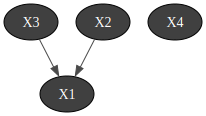

In [251]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

cbn = gum.fastBN("X1<-X2;X4;X1<-X3")
gnb.showBN(cbn)

### The Dataset

In [252]:
import pandas as pd

data = pd.read_csv( "data/bn_data.csv" , sep='\t')
data

,X1,X2,X3,X4
0,0.56,0.48,0.60,0.05
1,0.46,0.40,0.45,0.26
2,0.58,0.62,0.69,0.76
3,0.45,0.57,0.52,0.44
4,0.35,0.69,0.46,0.69
...,...,...,...,...
994,0.64,0.22,0.57,0.54
995,0.37,0.62,0.46,0.93
996,0.52,0.46,0.53,0.16
997,0.36,0.57,0.42,0.51


### Structure MCMC

In [253]:
RESIDUALS

0

In [254]:
PARAMS

0

In [255]:
NUM_ITERATIONS = 100

posterior, G, Gs = structured_MCMC(data, NUM_ITERATIONS)



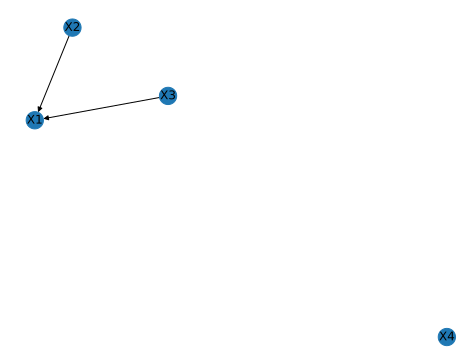

In [285]:
# get the key with the max value
max_key = min(Gs, key=Gs.get)
nx.draw(list(Gs.keys())[1], with_labels=True)


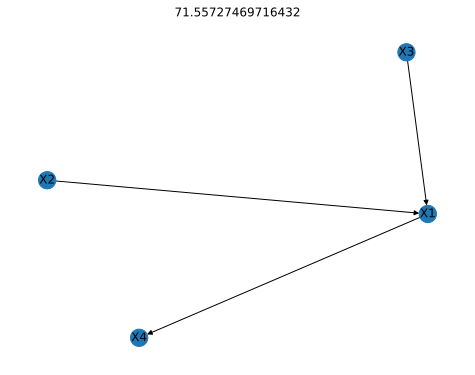

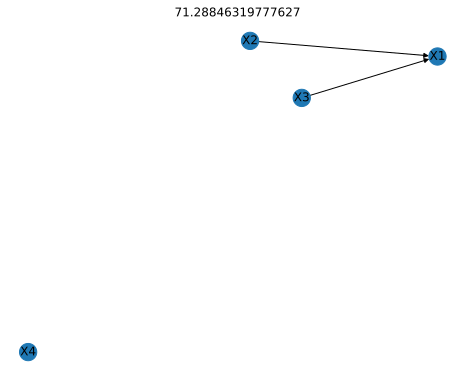

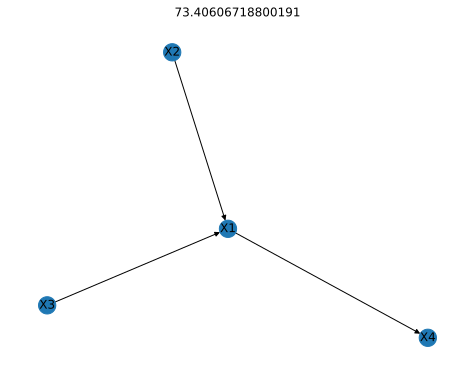

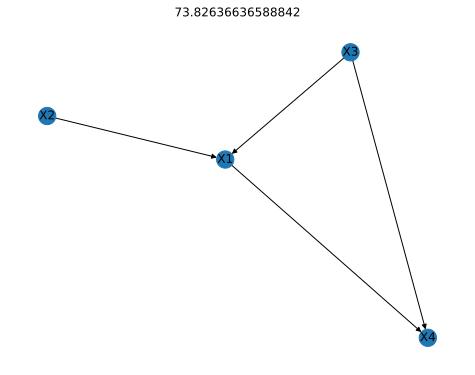

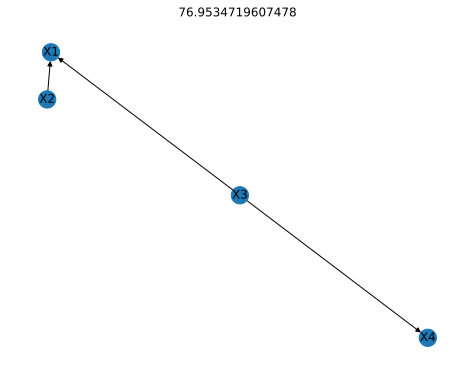

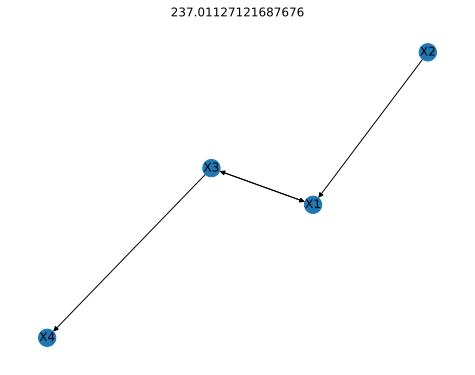

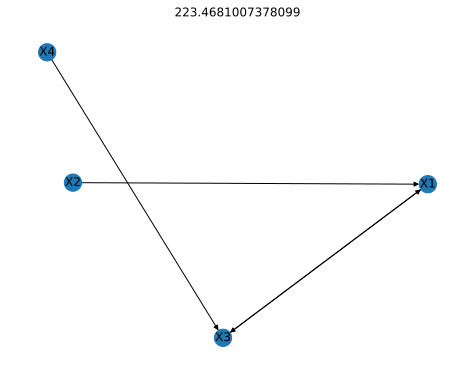

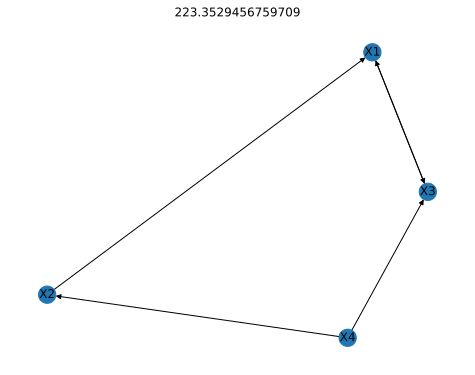

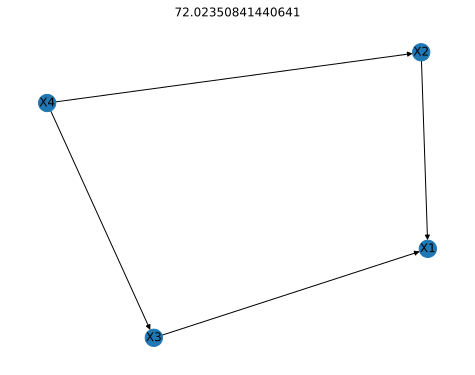

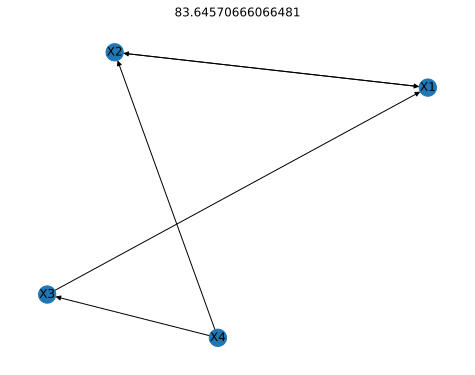

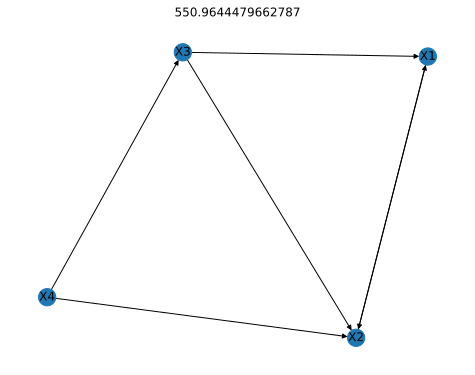

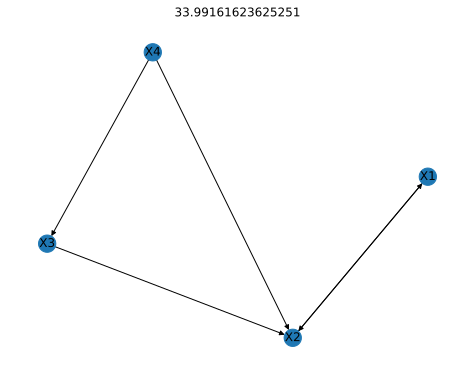

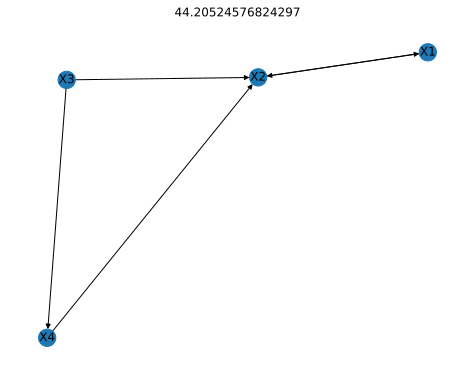

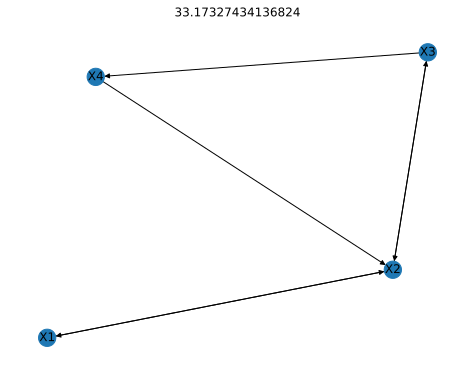

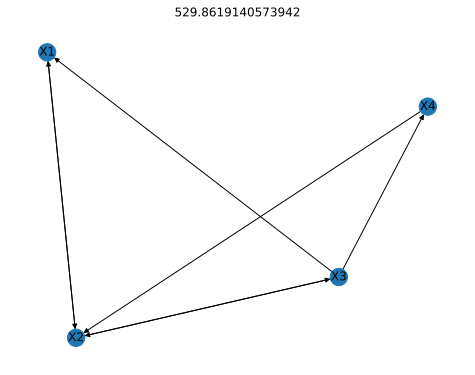

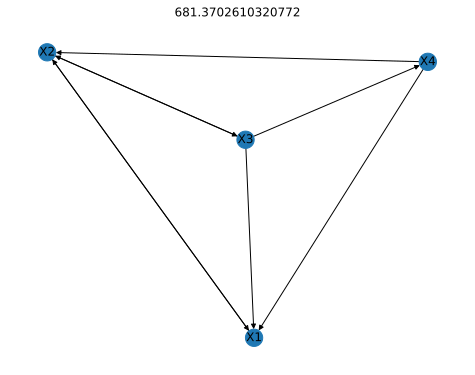

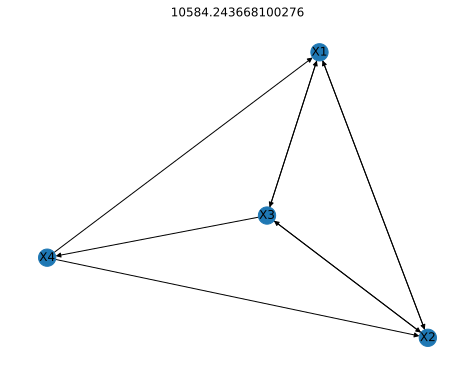

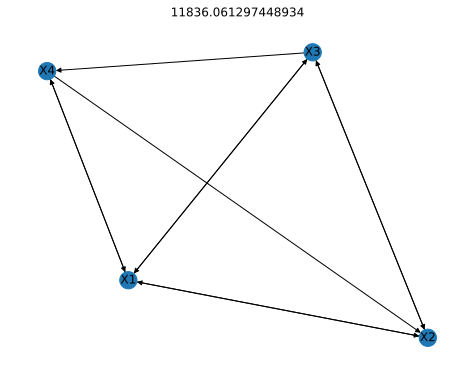

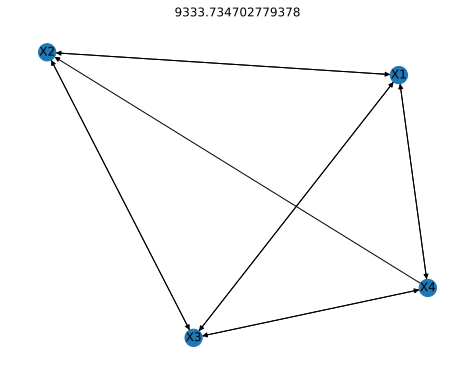

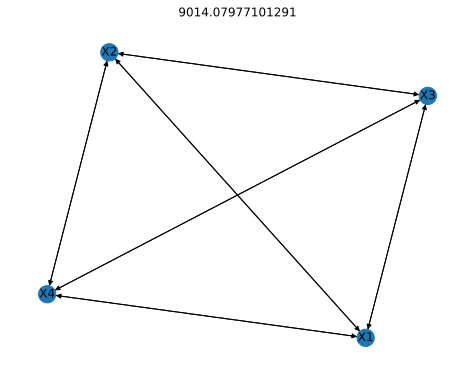

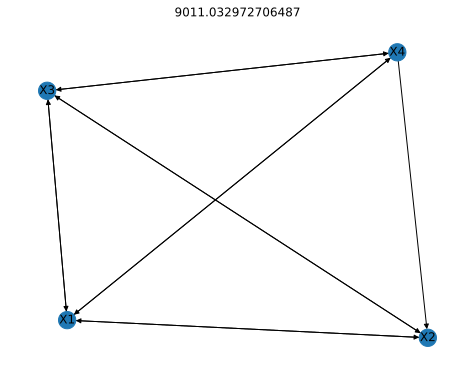

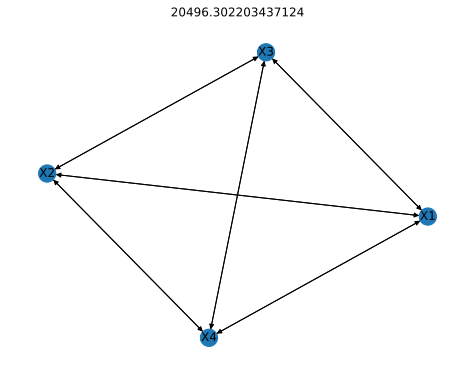

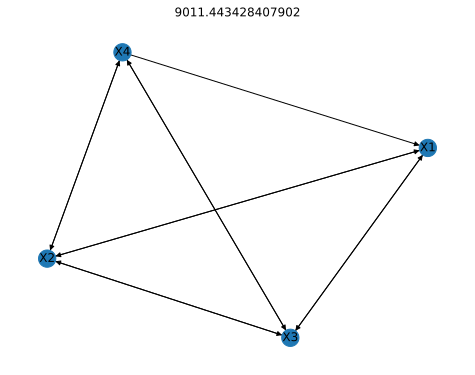

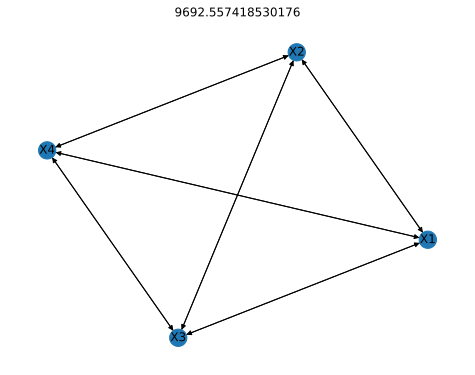

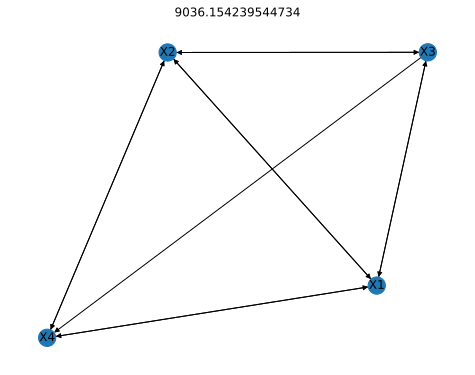

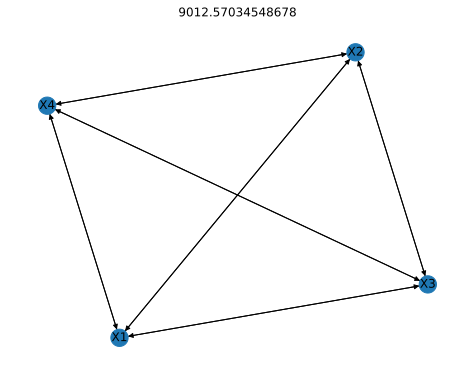

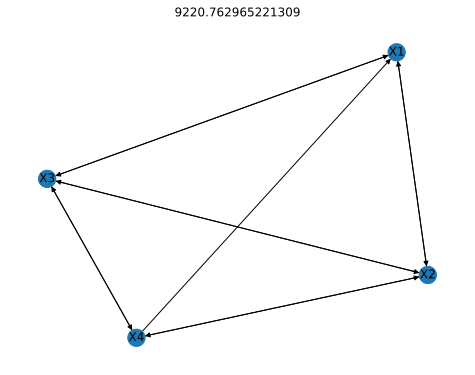

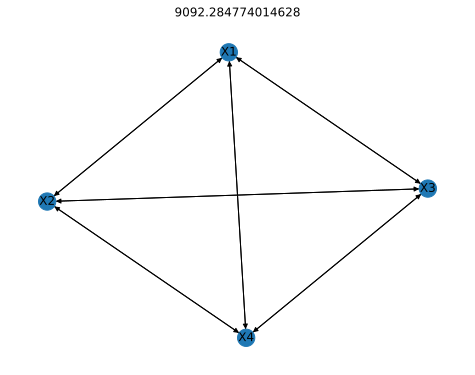

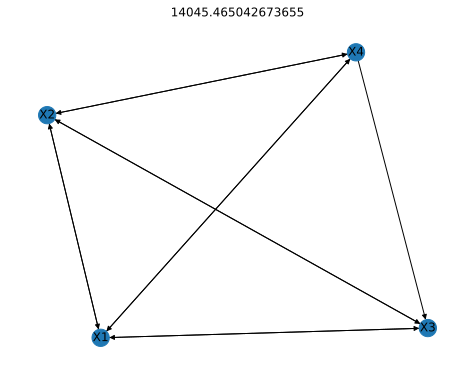

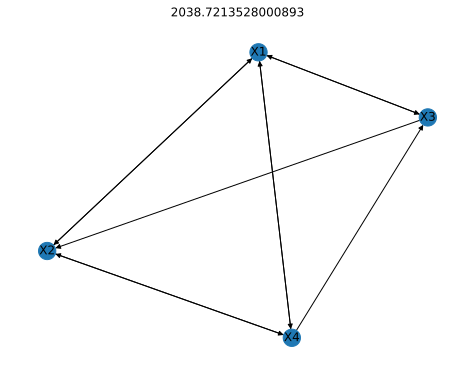

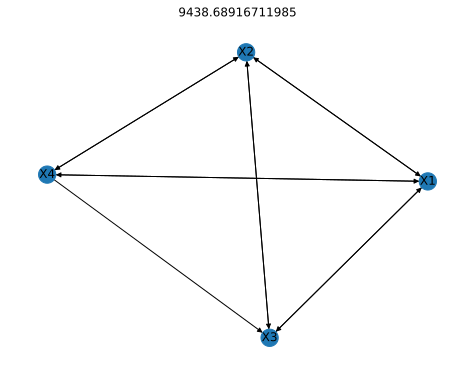

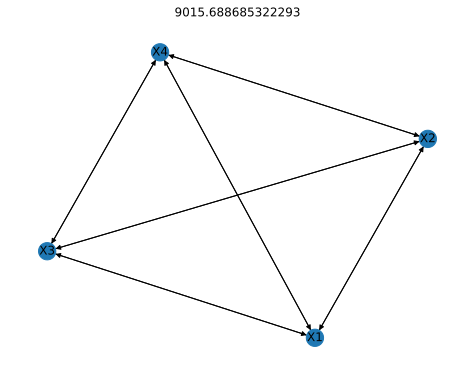

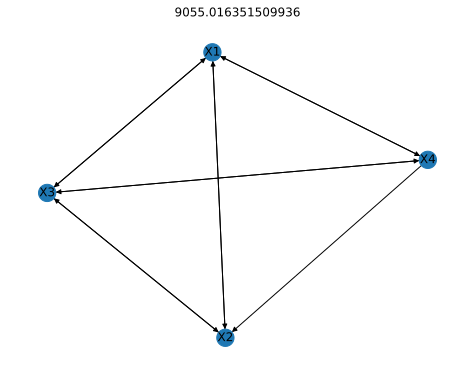

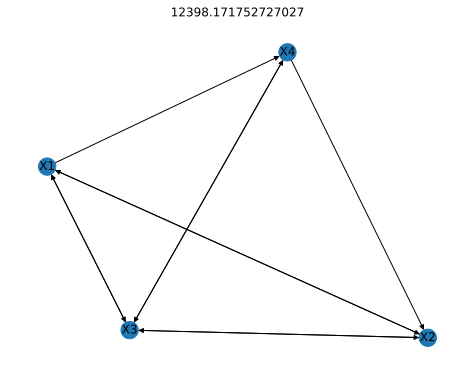

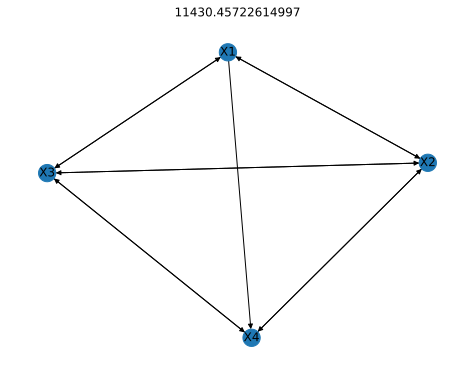

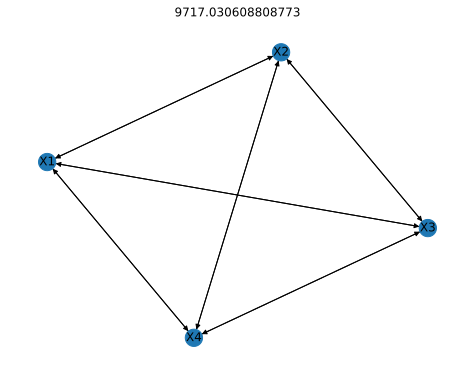

In [280]:
# for each graph in Gs, plot the graph
for graph, post in zip(Gs.keys(), Gs.values()):
    nx.draw(graph, with_labels=True)
    # set title
    plt.title(post)
    plt.show()

In [241]:
list(simulation.keys())[0]

'X1'

AttributeError: 'numpy.str_' object has no attribute 'is_directed'

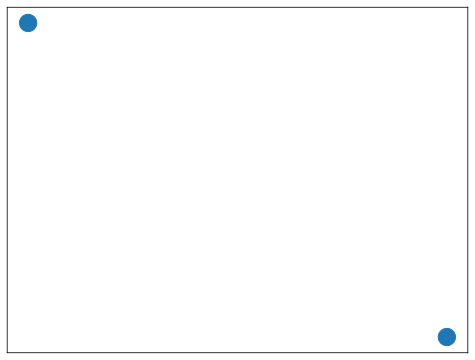

In [240]:
# use networkx to visualise graph G
import networkx as nx

N = len(G)
nx.draw(list(simulation.keys())[0], with_labels=True)
#nx.draw(G[N-1], with_labels=True)

## Convergence Analysis

In [114]:
import matplotlib.pyplot as plt

def plot_edges_trace(graphs):
    # Compute the number of edges in each graph
    num_edges = [G.number_of_edges() for G in graphs]

    fig, ax = plt.subplots()
    ax.plot(num_edges)

    ax.set_title("Trace plot of the number of edges")
    ax.set_xlabel("Step")
    ax.set_ylabel("Number of edges")

    plt.show()
    

import matplotlib.pyplot as plt

def plot_posterior_trace(posteriors):
    
    fig, ax = plt.subplots()
    ax.plot(posteriors)

    ax.set_title("Trace plot of the posterior probability")
    ax.set_xlabel("Step")
    ax.set_ylabel("Posterior probability")

    plt.show()


### Test

In [75]:
import numpy as np

In [6]:
import pandas as pd
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BicScore

def compute_posterior(G, data):
    # Convert the NetworkX graph to a pgmpy BayesianModel
    model = BayesianModel(G.edges())

    # Fit the model to the data using maximum likelihood estimation
    model.fit(data, estimator=MaximumLikelihoodEstimator)

    # Compute the BIC score of the model
    bic = BicScore(data)
    score = bic.score(model)

    # Convert the BIC score to a posterior probability
    posterior = np.exp(score)

    return posterior

In [11]:
data.columns

Index(['X1', 'X2', 'X3', 'X4'], dtype='object')

In [77]:
model1 = BayesianNetwork([('X3', 'X1'), ('X2', 'X1')])
model1.add_node("X4")
model1.fit(data)

In [78]:
bic = BicScore(data)
bic1 = bic.score(model1)
print(bic1)

-2731725.4195008655


In [79]:
model2 = BayesianNetwork([('X3', 'X1'), ('X2', 'X1'), ('X1', 'X4')])
model2.fit(data)

In [80]:
bic = BicScore(data)
bic2 = bic.score(model2)
print(bic2)

-2762225.9681480443


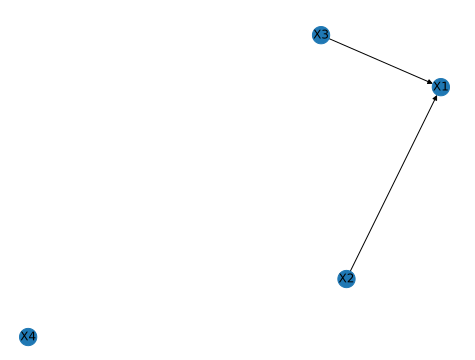

In [47]:
G = nx.DiGraph()
[G.add_node(node) for node in data.columns]

G.add_edges_from([('X3', 'X1'), ('X2', 'X1')])

# plot G
nx.draw(G, with_labels=True)

In [48]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianNetwork(G.edges())
model.fit(data)

In [50]:
# visualise the model
from pgmpy.estimators import BayesianEstimator

estimator = BayesianEstimator(model, data)
cpd_X1 = estimator.estimate_cpd('X1', prior_type="BDeu", equivalent_sample_size=10)
cpd_X2 = estimator.estimate_cpd('X2', prior_type="BDeu", equivalent_sample_size=10)
cpd_X3 = estimator.estimate_cpd('X3', prior_type="BDeu", equivalent_sample_size=10)
